<a href="https://colab.research.google.com/github/bo-cheng-tsai/homework/blob/main/week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
from transformers import BertTokenizer, BertModel

In [ ]:
# Step 1: 加載新聞情緒數據
dataset = load_dataset("takala/financial_phrasebank", "sentences_50agree")
sentences = dataset["train"]["sentence"]

# 使用 BERT 將新聞句子嵌入向量
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
device = "cuda" if torch.cuda.is_available() else "cpu"
bert_model.to(device)

# 嵌入函數
def embed_sentences_in_batches(sentences, batch_size=32):
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        inputs = tokenizer(batch, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
        torch.cuda.empty_cache()
    return np.vstack(embeddings)

print("Embedding sentences...")
embedded_sentences = embed_sentences_in_batches(sentences)
print("Sentence embedding complete.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for takala/financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/takala/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding sentences...
Sentence embedding complete.


In [ ]:
# Step 2: 加載股價數據
stock_id = "2330.TW"
end = dt.date.today()
start = end - dt.timedelta(days=365 * 2)
stock_data = yf.download(stock_id, start=start, end=end)
stock_data['5_SMA'] = stock_data['Close'].rolling(window=5).mean()
stock_data['10_SMA'] = stock_data['Close'].rolling(window=10).mean()
stock_data['Price_Change'] = stock_data['Close'].diff().shift(-1)  # 計算股價變動幅度
stock_data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Step 2: 加載股價數據
stock_id = "2330.TW"
end = dt.date.today()
start = end - dt.timedelta(days=365 * 2)
stock_data = yf.download(stock_id, start=start, end=end)
stock_data['5_SMA'] = stock_data['Close'].rolling(window=5).mean()
stock_data['10_SMA'] = stock_data['Close'].rolling(window=10).mean()
stock_data['Price_Change'] = stock_data['Close'].diff().shift(-1)  # 計算股價變動幅度
stock_data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Step 3: 合併數據
stock_features = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
scaler = StandardScaler()
scaled_stock_features = scaler.fit_transform(stock_features)

# 假設每條新聞對應一天的股價
news_features = embedded_sentences[:len(stock_data)]

# 拼接新聞情緒特徵與股價特徵
multi_modal_features = np.hstack([scaled_stock_features, news_features])
labels = stock_data['Price_Change'].values  # 目標為股價變動幅度

In [ ]:
# Step 4: 數據集分割
X_train, X_test, y_train, y_test = train_test_split(multi_modal_features, labels, test_size=0.2, shuffle=False)

In [ ]:
# Step 5: 定義多模態回歸模型
class MultiModalRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(MultiModalRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
model = MultiModalRegressionModel(input_dim).to(device)

In [ ]:
# Step 6: 訓練模型
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(features).squeeze()  # 回歸輸出為一維
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/200, Loss: 114.1425
Epoch 2/200, Loss: 42.8270
Epoch 3/200, Loss: 22.5037
Epoch 4/200, Loss: 16.6771
Epoch 5/200, Loss: 11.4990
Epoch 6/200, Loss: 7.7993
Epoch 7/200, Loss: 4.5268
Epoch 8/200, Loss: 4.9069
Epoch 9/200, Loss: 4.5056
Epoch 10/200, Loss: 4.2566
Epoch 11/200, Loss: 3.6538
Epoch 12/200, Loss: 3.0846
Epoch 13/200, Loss: 3.0852
Epoch 14/200, Loss: 2.4351
Epoch 15/200, Loss: 2.4328
Epoch 16/200, Loss: 3.0487
Epoch 17/200, Loss: 2.6880
Epoch 18/200, Loss: 2.8620
Epoch 19/200, Loss: 3.2325
Epoch 20/200, Loss: 3.1213
Epoch 21/200, Loss: 3.0534
Epoch 22/200, Loss: 3.1642
Epoch 23/200, Loss: 3.5147
Epoch 24/200, Loss: 3.8384
Epoch 25/200, Loss: 4.2943
Epoch 26/200, Loss: 4.2204
Epoch 27/200, Loss: 4.1989
Epoch 28/200, Loss: 3.6321
Epoch 29/200, Loss: 3.8209
Epoch 30/200, Loss: 3.5602
Epoch 31/200, Loss: 4.6558
Epoch 32/200, Loss: 5.1702
Epoch 33/200, Loss: 4.0170
Epoch 34/200, Loss: 4.9531
Epoch 35/200, Loss: 7.9546
Epoch 36/200, Loss: 7.2264
Epoch 37/200, Loss: 8.8637
Epoc

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Step 7: 評估模型
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for features, targets in test_loader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features).squeeze()
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(targets.cpu().numpy())

# 計算評估指標
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 23.0237
R-squared (R²): -0.6145


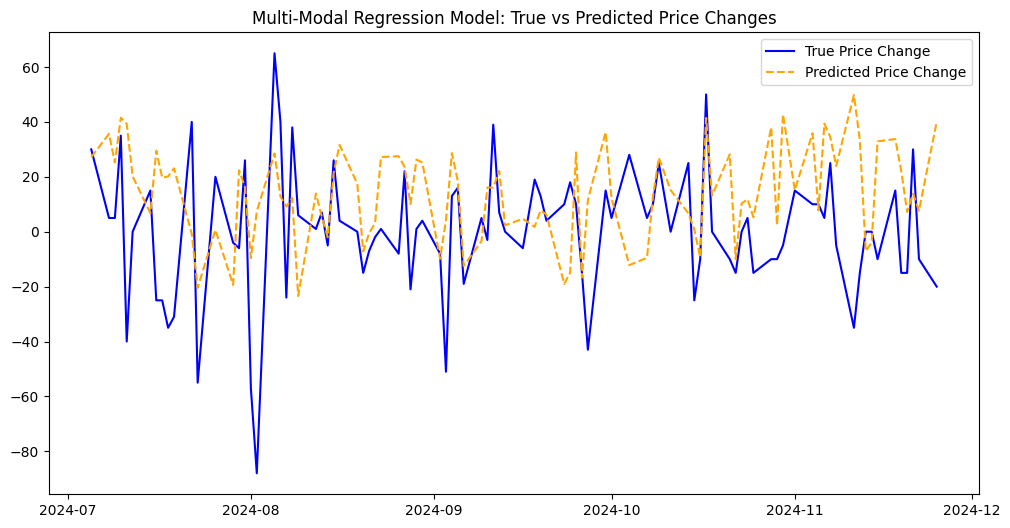

In [ ]:
# Step 8: 可視化結果
import matplotlib.pyplot as plt
test_dates = stock_data.iloc[-len(X_test):].index
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actuals, label="True Price Change", color="blue")
plt.plot(test_dates, predictions, label="Predicted Price Change", color="orange", linestyle="--")
plt.title("Multi-Modal Regression Model: True vs Predicted Price Changes")
plt.legend()
plt.show()